# Анализ результатов A/B теста

Имеется крупный интернет-магазин. Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки.

В нашем распоряжении есть следующие данные:
*	файл описания 9 гипотез с указанными параметрами Reach, Impact, Confidence, Effort для каждой гипотезы;
*	файл с данными по заказам A/B теста по дням;
*	файл с данными количества пользователей A/B теста по дням.

**Цель исследования**:
1. Приоритизировать гипотезы фреймворками ICE и RICE;
2. Проанализировать результаты A/B теста.

**Оглавление проекта**
1. [Изучение данных и подготовка их к анализу](#start)
    * 1.1. [Предобработка данных](#preprocessing)
    * 1.2. [Вывод по данным](#conclusion_1)
2. [Приоритизация гипотез](#priority)
    * 2.1. [Вывод по приоритизации](#conclusion_2)
3. [Анализ A/B-теста](#analysis)
    * 3.1. [График кумулятивной выручки по группам](#analysis_1)
    * 3.2. [График кумулятивного среднего чека по группам](#analysis_2)
    * 3.3. [График относительного изменения кумулятивного среднего чека групп](#analysis_3)
    * 3.4. [График кумулятивной конверсии по группам](#analysis_4)
    * 3.5. [График относительного изменения кумулятивной конверсии групп](#analysis_5)
    * 3.6. [Точечный график количества заказов по пользователям](#analysis_6)
    * 3.7. [Подсчет перцентилей количества заказов на пользователя](#analysis_7)
    * 3.8. [Точечный график стоимостей заказов](#analysis_8)
    * 3.9. [Подсчет перцентилей стоимости заказов](#analysis_9)
    * 3.10. [Статистическая значимость различий в конверсии между группами по сырым данным](#analysis_10)
    * 3.11. [Cтатистическая значимость различий в среднем чеке заказа между группами по сырым данным](#analysis_11)
    * 3.12. [Cтатистическая значимость различий в конверсии между группами по очищенным данным](#analysis_12)
    * 3.13. [Cтатистическая значимость различий в среднем чеке заказа между группами по очищенным данным](#analysis_13)
4. [Выводы по результатам теста](#conclusion)

## Изучение данных и подготовка их к анализу
<a id="start"></a>
Импортируем нужные библиотеки, загрузим данные, преобразуем значения в столбцах при необходимости, проверим на дубликаты.

In [1]:
# импорт необходимых библиотек
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
# загрузка данных в переменные

try:
    hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv', sep=','),  # гипотезы
    pd.read_csv('/datasets/orders.csv', sep=','),  # заказы
    pd.read_csv('/datasets/visitors.csv', sep=','),  # посетители интернет-магазина
    )
except:
    hypothesis, orders, visitors = (
    pd.read_csv('C:/Data/hypothesis.csv', sep=','),  
    pd.read_csv('C:/Data/orders.csv', sep=','),  
    pd.read_csv('C:/Data/visitors.csv', sep=','),  
    )

In [3]:
# знакомство с данными в переменных
files_dict = {'hypothesis':hypothesis, 'orders':orders, 'visitors':visitors}
for i, j in files_dict.items():
    print(f"Получение информации по файлу {i}:")
    print('')
    j.info()
    print('')

Получение информации по файлу hypothesis:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

Получение информации по файлу orders:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

Получение информации по файлу visitors:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2

Знакомство с таблицей гипотез:

In [4]:
pd.set_option('display.max_colwidth', 1000)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Знакомство с таблицей заказов:

In [5]:
display(orders.head())
# Вывод описательной статистики для таблицы заказов:
orders.describe(include='all').T

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
transactionId,1197,NaN,NaN,NaN,2.15562e+09,1.22908e+09,1.06239e+06,1.16678e+09,2.14519e+09,3.23774e+09,4.29386e+09
visitorId,1197,NaN,NaN,NaN,2.16596e+09,1.23601e+09,5.11459e+06,1.11183e+09,2.21798e+09,3.17761e+09,4.28387e+09
date,1197,31,2019-08-05,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revenue,1197,NaN,NaN,NaN,8348.01,39191.1,50,1220,2978,8290,1.2945e+06
group,1197,2,B,640,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Знакомство с таблицей посетителей:

In [6]:
display(visitors.head())
visitors.describe(include='all').T

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,62,31,2019-08-24,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
group,62,2,A,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visitors,62,NaN,NaN,NaN,607.29,114.401,361,534,624.5,710.5,770


### Предобработка данных
<a id="preprocessing"></a>

In [7]:
# преобразование стиля заголовка в столбцах таблиц
hypothesis = hypothesis.rename(columns={'Hypothesis': 'hypothesis', 'Reach': 'reach', 'Impact': 'impact', 
                                        'Confidence': 'confidence', 'Efforts': 'efforts'})
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})

In [8]:
# преобразование данных о времени
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [9]:
# проверка таблиц на явные дубликаты 
print('Найдено дубликатов в таблице orders:', orders.duplicated().sum())
print('Найдено дубликатов в таблице visitors:', visitors.duplicated().sum())

Найдено дубликатов в таблице orders: 0
Найдено дубликатов в таблице visitors: 0


In [10]:
# проверка диапазона дней в таблицах
display(visitors['date'].unique())
orders['date'].sort_values().unique()

array(['2019-08-01T00:00:00.000000000', '2019-08-02T00:00:00.000000000',
       '2019-08-03T00:00:00.000000000', '2019-08-04T00:00:00.000000000',
       '2019-08-05T00:00:00.000000000', '2019-08-06T00:00:00.000000000',
       '2019-08-07T00:00:00.000000000', '2019-08-08T00:00:00.000000000',
       '2019-08-09T00:00:00.000000000', '2019-08-10T00:00:00.000000000',
       '2019-08-11T00:00:00.000000000', '2019-08-12T00:00:00.000000000',
       '2019-08-13T00:00:00.000000000', '2019-08-14T00:00:00.000000000',
       '2019-08-15T00:00:00.000000000', '2019-08-16T00:00:00.000000000',
       '2019-08-17T00:00:00.000000000', '2019-08-18T00:00:00.000000000',
       '2019-08-19T00:00:00.000000000', '2019-08-20T00:00:00.000000000',
       '2019-08-21T00:00:00.000000000', '2019-08-22T00:00:00.000000000',
       '2019-08-23T00:00:00.000000000', '2019-08-24T00:00:00.000000000',
       '2019-08-25T00:00:00.000000000', '2019-08-26T00:00:00.000000000',
       '2019-08-27T00:00:00.000000000', '2019-08-28

array(['2019-08-01T00:00:00.000000000', '2019-08-02T00:00:00.000000000',
       '2019-08-03T00:00:00.000000000', '2019-08-04T00:00:00.000000000',
       '2019-08-05T00:00:00.000000000', '2019-08-06T00:00:00.000000000',
       '2019-08-07T00:00:00.000000000', '2019-08-08T00:00:00.000000000',
       '2019-08-09T00:00:00.000000000', '2019-08-10T00:00:00.000000000',
       '2019-08-11T00:00:00.000000000', '2019-08-12T00:00:00.000000000',
       '2019-08-13T00:00:00.000000000', '2019-08-14T00:00:00.000000000',
       '2019-08-15T00:00:00.000000000', '2019-08-16T00:00:00.000000000',
       '2019-08-17T00:00:00.000000000', '2019-08-18T00:00:00.000000000',
       '2019-08-19T00:00:00.000000000', '2019-08-20T00:00:00.000000000',
       '2019-08-21T00:00:00.000000000', '2019-08-22T00:00:00.000000000',
       '2019-08-23T00:00:00.000000000', '2019-08-24T00:00:00.000000000',
       '2019-08-25T00:00:00.000000000', '2019-08-26T00:00:00.000000000',
       '2019-08-27T00:00:00.000000000', '2019-08-28

In [11]:
# проверяем распределение посетителей по группам
orders.groupby('group')['visitor_id'].count()

group
A    557
B    640
Name: visitor_id, dtype: int64

In [12]:
# проверяем и выделяем количество пользователей, которые входят в обе группы тестирования
crossingGroups = orders.groupby('visitor_id', as_index=False).agg({'group':'nunique'}).query('group > 1')
len(crossingGroups)

58

In [13]:
# всего уникальных пользователей
len(orders.groupby('visitor_id'))

1031

In [14]:
# процент пользователей засветившихся в обеих группах
round(58*100/1031, 2)

5.63

Пересечение групп сильно влияет на результаты теста, если процент достаточно большой. Для учебного проекта пренебрежем этим пересечением.

### Вывод по данным
<a id="conclusion_1"></a>
В таблице **hypothesis** 5 столбцов:
*   `Hypothesis` — краткое описание гипотезы
*   `Reach` — охват пользователей по 10-балльной шкале
*   `Impact` — влияние на пользователей по 10-балльной шкале
*   `Confidence` — уверенность в гипотезе по 10-балльной шкале
*   `Efforts` - затраты ресурсов на проверку гипотезы по 10-балльной шкале.
    
Пропущенных значений и дубликатов в таблице нет. Названия колонок преобразованы к змеиному регистру. 

В таблице **orders** 5 столбцов:
*   `transactionId` — идентификатор заказа
*   `visitorId` — идентификатор пользователя, совершившего заказ
*   `date` — дата, когда был совершён заказ
*   `revenue` — выручка заказа
*   `group` — группа A/B-теста, в которую попал заказ.
    
Пропущенных значений и дубликатов в таблице нет. Названия колонок преобразованы к змеиному регистру. Столбец `date` переведен в тип datetime.

В таблице **visitors** 3 столбца:
*   `date` — дата
*   `group` — группа A/B-теста
*   `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.
    
Пропущенных значений и дубликатов в таблице нет. Столбец `date` переведен в тип datetime.

Судя по данным A/B-тест длился ровно 1 месяц (31 день) в течение августа 2019 года.

Посетители интернет-сайта распределены по группам тестирования неодинаково, разница довольно существенная (около 15%). Так как у нас нет явного технического задания на процент соотношения пользователей в выборках, то пренебрежем этим замечанием.

Выявлены пользователи, которые оказались в обеих группах тестирования и делали заказы, их более 5%. Возможно, им не нравилась новая функциональность, и они через техническую поддержку просили вернуть им старую. К сожалению, у нас нет данных, чтобы это изучить. Если бы проект был не учебный, стоило бы разобраться с причинами и, возможно, остановить тест.

## Приоритизация гипотез
<a id="priority"></a>

### Применение фреймворка ICE для приоритизации гипотез

Используем формулу для расчета коэффициента методом ICE: $$ ICE=\frac{Impact*Confidence}{Efforts} $$

In [15]:
hypothesis['ice'] = round((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'], 2)

hypothesis.sort_values(by='ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


### Применение фреймворка RICE для приоритизации гипотез

Используем формулу для расчета коэффициента методом RICE: $$ RICE=\frac{Reach*Impact*Confidence}{Efforts} $$

In [16]:
hypothesis['rice'] = round((hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'], 2)

# ранжируем и выделяем цветом полученные коэффициенты для гипотез по фреймфоркам
cm = sns.light_palette("green", as_cmap=True)
hypothesis.sort_values(by='rice', ascending=False).style.background_gradient(cmap=cm, subset=['ice', 'rice'])

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3


### Вывод по приоритизации
<a id="conclusion_2"></a>
После применения фреймворка ICE наиболее перспективными были гипотезы с индексами: 8, 0, 7.<br>
После применения фреймворка RICE наиболее перспективными стали гипотезы с индексами: 7, 2, 0, 6.<br>

С большим отрывом лидирует гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" (индекс 7), в этом помогло максимальное значение параметра охвата пользователей (Reach). По той же причине на втором месте оказалась гипотеза "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" (индекс 2) при относительно небольших затратах ресурсов. А вот гипотеза "Запустить акцию, дающую скидку на товар в день рождения" выпала из перспективных вовсе, так как охватывает малую аудиторию. <br> Гипотеза "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" (индекс 0) удержалась в тройке лидеров за счет высоких показателей влияния на пользователей и уверенности в гипотезе, но с ней сравнялась гипотеза "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию" (индекс 6) за счет параметра Reach.

## Анализ A/B-теста
<a id="analysis"></a>

### График кумулятивной выручки по группам
<a id="analysis_1"></a>

In [17]:
# создаем датафрейм datesGroups с уникальными парами значений 'date' и 'group' таблицы orders
datesGroups = orders[['date','group']].drop_duplicates()

# создаем переменную ordersAggregated, содержащую агрегированные данные таблицы orders по дням:
# дату;
# группу A/B-теста;
# число уникальных заказов в группе теста по указанную дату включительно;
# число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
# суммарную выручку заказов в группе теста по указанную дату включительно.

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# создаем переменную visitorsAggregated, содержащую агрегированные данные таблицы visitors по дням:
# дату;
# группу A/B-теста;
# количество уникальных посетителей в группе теста по указанную дату включительно.

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем в кумулятивную таблицу и переименовываем ее столбцы
cumulativeData = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


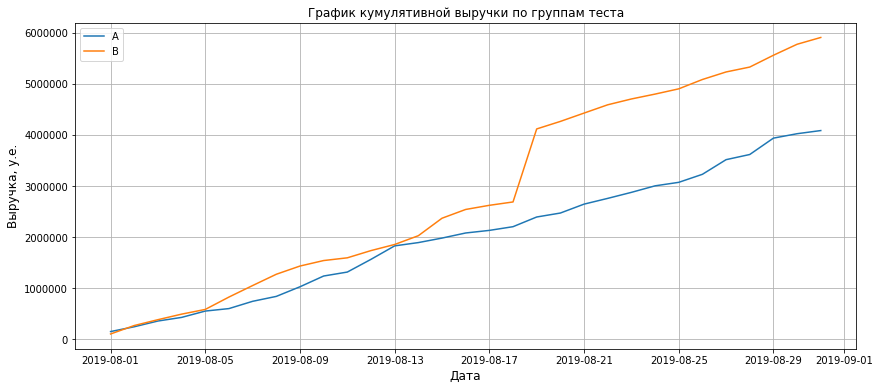

In [18]:
# делаем срез по группам и выделяем даты, выручку и число заказов
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# строим график кумулятивной выручки по группам
plt.figure(figsize=(14,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам теста')
plt.xlabel('Дата', size=12)
plt.ylabel('Выручка, у.е.', size=12)
plt.grid()
plt.legend();

Практически с первого дня теста сегмент B вырвался вперед по выручке и продолжал лидировать до конца теста, причем если сначала преимущество было незначительным, то около 18-19 августа резко ушел в отрыв. Это может сигнализировать о всплесках числа заказов в группе B, либо о появлении аномально дорогих заказов. По сегменту А выручка почти равномерно увеличивается в течение всего теста.

### График кумулятивного среднего чека по группам
<a id="analysis_2"></a>

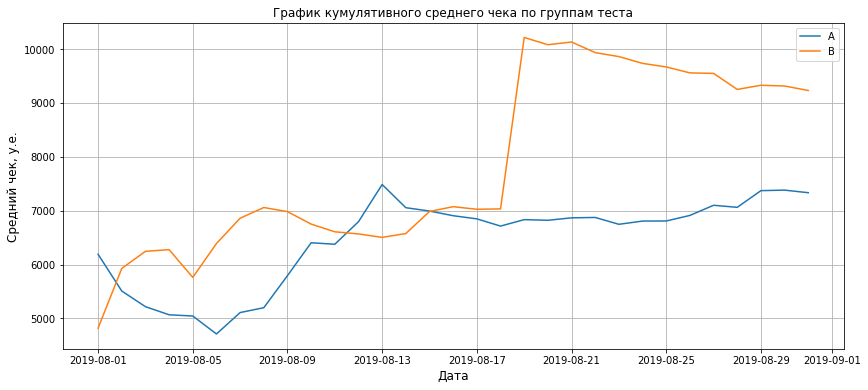

In [19]:
# строим аналогичный график для средних чеков
plt.figure(figsize=(14,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам теста')
plt.xlabel('Дата', size=12)
plt.ylabel('Средний чек, у.е.', size=12)
plt.grid()
plt.legend();

Кумулятивное значение среднего чека по сегментам сильно изменялось большую часть теста. Средний чек становится равномерным ближе к концу теста: установился для группы A около 7000 у.е., и после резкого роста постепенно снижается для группы B. Вероятно, в группу B все-таки попали крупные заказы 19 августа (резкий всплеск).

### График относительного изменения кумулятивного среднего чека групп
<a id="analysis_3"></a>
Строим график относительного изменения кумулятивного среднего чека группы B к группе A

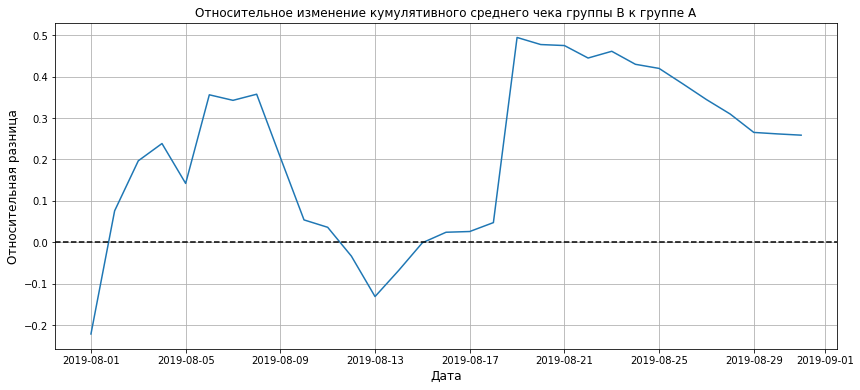

In [20]:
# собираем данные групп в одном датафрейме, строим отношение средних чеков и добавляем горизонтальную ось
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(14,6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1
        )
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата', size=12)
plt.ylabel('Относительная разница', size=12)
plt.grid();

Результаты теста значительно и резко менялись в несколько дат, в самом начале теста и 19-го августа для группы B и в период с 8-го по 13-ое августа для группы А. Видимо, именно тогда были совершены аномальные заказы в группах.

### График кумулятивной конверсии по группам
<a id="analysis_4"></a>

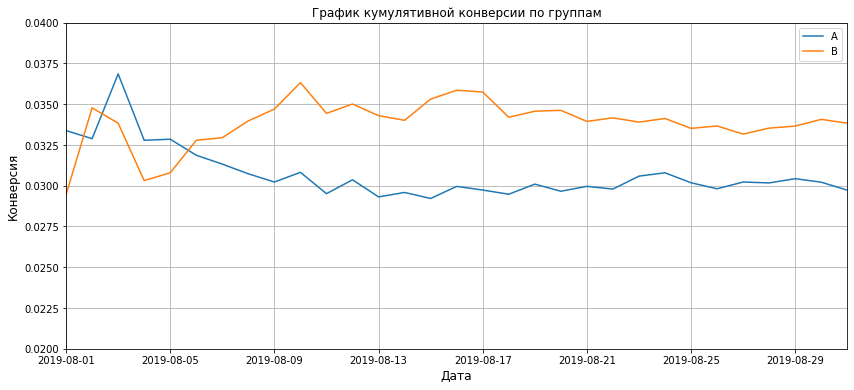

In [21]:
# добавим в кумулятивную таблицу cumulativeData столбец 'conversion' c отношением числа заказов к количеству пользователей
# в указанной группе в указанный день.

cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
# объявляем переменные , в которых сохраним данные о заказах в сегментах A и B соответственно.
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим график кумулятивной конверсии по дням по группам.
plt.figure(figsize=(14,6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата', size=12)
plt.ylabel('Конверсия', size=12)
plt.grid()
plt.legend()
# задаем масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0.020, 0.040]);

В первые дни конверсия группы А была выше, но с 6-го августа ситуация изменилась. Постепенно сегмент В вышел в лидеры по конверсии, выровнялся и зафиксировался примерно около одного значения, больше значения сегмента А примерно на 0.4%.

### График относительного изменения кумулятивной конверсии групп
<a id="analysis_5"></a>
Строим график относительного изменения кумулятивной конверсии группы B к группе A

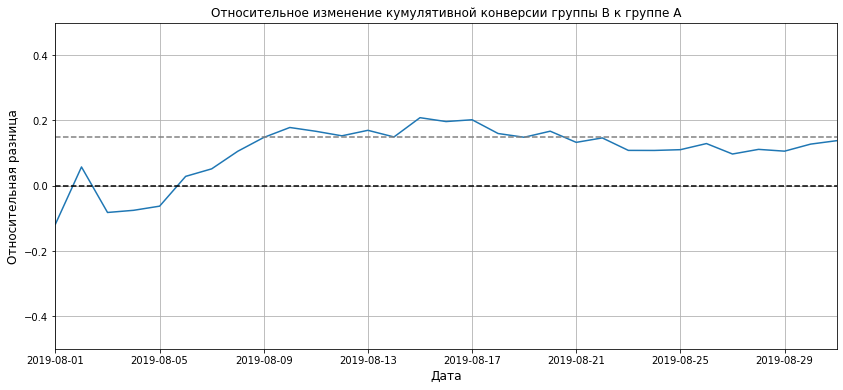

In [22]:
# собираем данные групп с конверсиями в одном датафрейме, строим их отношение и добавляем горизонтальную ось
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                               .merge(cumulativeDataB[['date','conversion']],
                                      on='date', how='left', suffixes=['A', 'B'])[['date', 'conversionA', 'conversionB']]
                              )
plt.figure(figsize=(14,6))
plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата', size=12)
plt.ylabel('Относительная разница', size=12)
plt.grid()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.5, 0.5]);

Почти с самого начала теста группа В лидирует по конверсии – становится лучше и лучше, а потом фиксируется около прироста в 15% относительно группы А.

### Точечный график количества заказов по пользователям
<a id="analysis_6"></a>

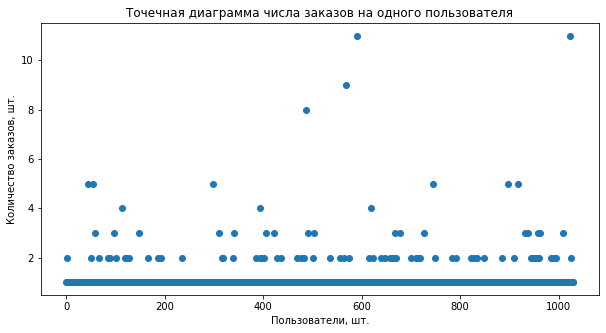

In [23]:
# создадим датафрейм c двумя столбцами: 'visitor_id' и 'orders', в котором будет число заказов по пользователям

ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'count'})
    .rename(columns={'transaction_id': 'orders'})
)
# строим точечную диаграмму методом scatter()
# по оси X будет количество наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(10,5))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.xlabel('Пользователи, шт.')
plt.ylabel('Количество заказов, шт.');

Пользователей заказавших более 2 раз совсем мало. Чтобы определиться с границой "нормальности" количества заказов посчитаем выборочные перцентели.

### Подсчет перцентилей количества заказов на пользователя
<a id="analysis_7"></a>
Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [24]:
print(np.percentile(ordersByUsers['orders'] , [95, 99]))

[2. 4.]


Не более 5% пользователей совершали больше двух заказов. И не более 1% больше 4 заказов. Примем за аномальных пользователей тех, кто совершил 3 заказа и более.

In [25]:
# посмотрим на границы количества заказов, если бы мы исключили пересекающихся пользователей в группах
print(np.percentile(ordersByUsers[np.logical_not(ordersByUsers['visitor_id'].
                                                 isin(crossingGroups['visitor_id']))]['orders'], [95, 99]))

[1. 2.]


### Точечный график стоимостей заказов
<a id="analysis_8"></a>

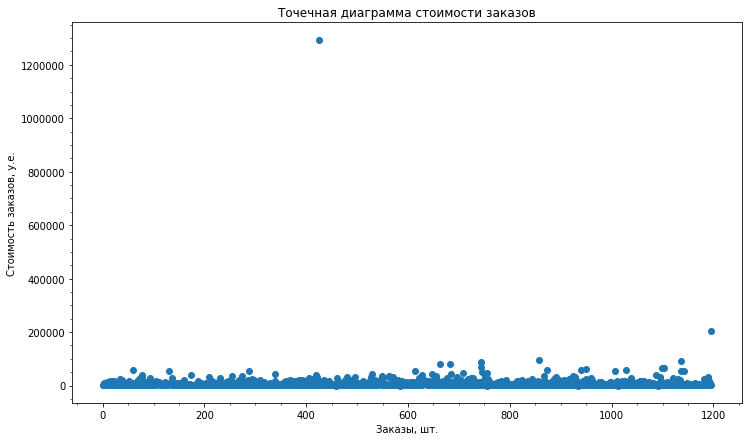

In [26]:
# строим точечную диаграмму методом scatter()
# по оси X будет количество заказов в orders
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(12,7))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма стоимости заказов')
plt.xlabel('Заказы, шт.')
plt.ylabel('Стоимость заказов, у.е.')
#plt.yticks(np.arange(0, 1200000, 50000))
plt.minorticks_on();

По графику примерно можно увидеть границу аномальных заказов - все что больше 50000 у.е.

### Подсчет перцентилей стоимости заказов
<a id="analysis_9"></a>
Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [27]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более чем у 5% заказов чек дороже 28000 у.е., и не больше чем у 1% заказов – дороже 58233 у.е. Примем за аномальные заказы такие, стоимость которых свыше 30000 у.е.

In [28]:
# посмотрим на границы стоимости заказов, если бы мы исключили пересекающихся пользователей в группах
print(np.percentile(orders[np.logical_not(orders['visitor_id'].isin(crossingGroups['visitor_id']))]['revenue'], [95, 99]))

[26785. 53904.]


Посчитали перцентели для выборки без заказов пересекающихся пользователей, есть изменение по количеству заказов. Можно было бы принять за аномальных пользователей таких, которые совершали от 2-ух заказов. Стоимость тоже изменилась, но там я бы все равно оставил границу в 30000.

### Статистическая значимость различий в конверсии между группами по сырым данным
<a id="analysis_10"></a>
Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным - без удаления аномальных пользователей. Применим тест Манна-Уитни.

Сформулируем нулевую и альтернативную гипотезы:
1. H0: данные в выборках взяты из одной и той же генеральной совокупности;
2. H1: данные в выборках взяты из разных генеральных совокупностей.

Если данные в выборках взяты из разных генеральных совокупностей, то, скорее всего, у них будут различаться средние, медианы и другие параметры.

In [29]:
# делаем срез для каждой группы по количеству посетителей на каждый день
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [30]:
# создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['visitor_id', 'orders']. 
# в них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

In [31]:
# объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
# тем, кто ничего не заказал, будут соответствовать нули -  
# их количество равно разнице между суммой посетителей и количеством записей о заказах для группы: 
# data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders']).
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [32]:
# Определяем критический уровень статистической значимости
alpha = 0.05

# считаем статистическую значимость различия конверсии по результатам теста,
# применим критерий Манна-Уитни и выведем p-value для сравнения конверсии между группами. 
results_1 = stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')
print('p-значение:', "{0:.5f}".format(results_1.pvalue))

if results_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

# выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1.
print('Относительный прирост конверсии:',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-значение: 0.01679
Отвергаем нулевую гипотезу
Относительный прирост конверсии: 0.138


P-value меньше 0.05, потому нулевую гипотезу отвергаем. Анализ «сырых данных» сообщает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы В к конверсии группы А равен 13.8%.

### Cтатистическая значимость различий в среднем чеке заказа между группами по сырым данным
<a id="analysis_11"></a>
Формулировки нулевой и альтернативной гипотезы остаются такими же как в предыдущем пункте.

In [33]:
results_2 = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                               orders[orders['group']=='B']['revenue'], alternative = 'two-sided')
print('p-значение:', "{0:.3f}".format(results_2.pvalue))

if results_2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Относительный прирост среднего чека:',
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-значение: 0.729
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека: 0.259


P-value больше 0.05 – статистически значимых отличий в среднем чеке между группами нет. Несмотря на то, что относительное различие среднего чека между сегментами составляет 25,9%, но это могло случиться из-за выбросов. Нужно проверить статистическую значимость различий в среднем чеке и конверсии между группами, исключив аномалии.

### Cтатистическая значимость различий в конверсии между группами по очищенным данным
<a id="analysis_12"></a>

In [34]:
# cделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, 
# совершивших заказы дороже 30000 у.е. — usersWithExpensiveOrders. 
# объединим их в таблице abnormalUsers, удалим дубликаты, отсортируем по возрастанию.
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitor_id']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

abnormalUsers

1099     148427295
18       199603092
928      204675465
23       237748145
37       249864742
           ...    
940     4003628586
627     4120364173
743     4133034833
499     4256040402
662     4266935830
Name: visitor_id, Length: 68, dtype: int64

In [35]:
# cоздаем переменные sampleAFiltered и sampleBFiltered, в которых сохраним очищенные данные о заказах —
# не включая аномальных пользователей.
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# считаем статистическую значимость различия конверсии по результатам теста по "очищенным" данным,
# применим критерий Манна-Уитни и выведем p-value для сравнения конверсии между группами. 
results_3 = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')
print('p-значение:', "{0:.5f}".format(results_3.pvalue))

if results_3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

# выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1.
print('Относительный прирост конверсии:',"{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-значение: 0.01334
Отвергаем нулевую гипотезу
Относительный прирост конверсии: 0.172


Как и в случае с сырыми данными, статистическая значимость достигнута. Сегмент B по конверсии лучше сегмента А. Относительный прирост конверсии стал еще больше.

### Cтатистическая значимость различий в среднем чеке заказа между группами по очищенным данным
<a id="analysis_13"></a>

In [36]:
results_4 = stats.mannwhitneyu(orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
                               orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'], alternative = 'two-sided')
print('p-значение:', "{0:.3f}".format(results_4.pvalue))

if results_4.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Относительный прирост среднего чека:',
      '{0:.3f}'.format(orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
                       /orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
                      )
     )

p-значение: 0.720
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека: -0.023


P-value по среднему чеку все так же больше 0.05 – статистически значимых отличий в среднем чеке между группами нет. А вот относительный прирост среднего чека совсем исчез после очистки данных от выбросов, более того он незначительно уменьшился по группе B (2%). Считаем, это допустимым исходя из p-value, то есть, что разницы между средними чеками нет.

In [37]:
# проверяем суммарную выручку по сегментам на очищенных данных
print('Суммарная выручка группы A:',
      orders[np.logical_and(orders['group'] == 'A',
                      np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].sum())

print('Суммарная выручка группы B:',
      orders[np.logical_and(orders['group'] == 'B',
                      np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].sum())

Суммарная выручка группы A: 2529855
Суммарная выручка группы B: 2923121


### Выводы по результатам теста
<a id="conclusion"></a>
По результатам анализа A/B теста можно сделать следующие выводы:

1. Сегмент B значительно лучше сегмента А по конверсии. Статистическая значимость различия присутствует и на "сырых" и на "очищенных" данных.
2. Улучшения по среднему чеку по сегменту B не наблюдается, но что более важно - нет ухудшения. Средний чек по группам не меняется.
3. Выручка по сегменту B лучше сегмента А (на основе графика кумулятивной выручки и суммарной выручки по "очищенным" данным).
4. Остановливаем тест, фиксируем, что сегмент B показывает себя лучше сегмента A.